In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, Bounds
from nelson_siegel_svensson.calibrate import errorfn_ns_ols, betas_ns_ols
# Create plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# Import gausian filter
from scipy.ndimage import gaussian_filter1d


In [2]:
sns.set(style="white")

color = '#1982C4'
color2 = '#FF595E'
color3 = '#8AC926'

# Loading dataset

In [3]:
def read_files(path, filenames):
    """Reads all files and returns a dataframe"""
    return pd.concat((pd.read_csv(path + f, skipinitialspace=True) for f in filenames))

In [4]:
path_opt = "./data/raw_data/"
filenames_opt = ["spx_eod_" + str(year) + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for year in range(2011, 2023) for month in range(1, 13)] + ["spx_eod_2023" + (str(month) if month >= 10 else "0" + str(month)) + ".csv" for month in range(1, 4)]
df = read_files(path_opt, filenames_opt)

In [5]:
# Filter after between 2011-02-11 and 2022-12-31
df = df[(df["[QUOTE_DATE]"] >= "2011-02-11") & (df["[QUOTE_DATE]"] <= "2022-12-31")]
len_after_first_read = len(df)

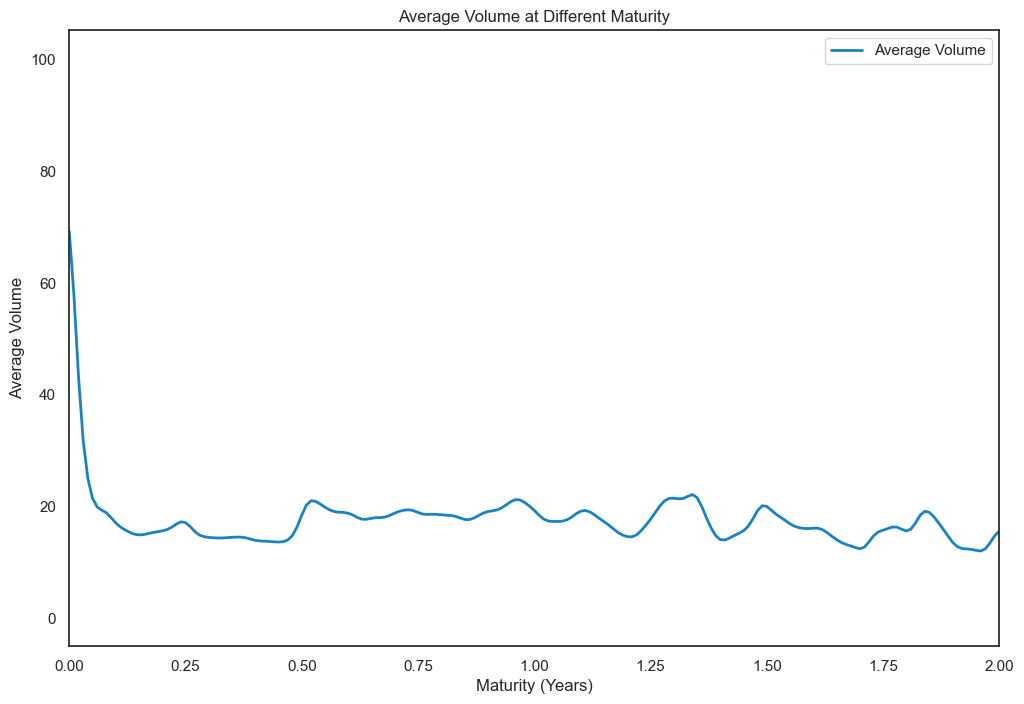

In [6]:
df["Date"] = pd.to_datetime(df["[QUOTE_DATE]"])
df["Maturity"] = pd.to_datetime(df["[EXPIRE_DATE]"]) - df["Date"]
df["Maturity"] = df["Maturity"].dt.days
df["Maturity"] = df["Maturity"] / 365
df["Volume"] = df["[C_VOLUME]"]
df["Volume"] = df["Volume"].fillna(0)
df["Volume"] = pd.to_numeric(df["Volume"], errors='coerce')
df["Maturity"] = df["Maturity"].round(2)


df_grouped = df.groupby("Maturity")["Volume"].mean().reset_index()
df_grouped["Average Volume"] = df_grouped["Volume"]
# Copying df to df_copy before applying gaussian filter
df["Average Volume"] = df["Volume"]
df_copy = df.copy()
df_grouped["Average Volume"] = gaussian_filter1d(df_grouped["Average Volume"], sigma=1.5)

# Add line for average for Maturity > 2 and for Maturity < 2
average_volume_2 = df[df["Maturity"] > 2]["Volume"].mean()
average_volume_0_2 = df[df["Maturity"] < 2]["Volume"].mean()

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_grouped, x="Maturity", y="Average Volume", label='Average Volume', color=color, linewidth=2)
plt.title("Average Volume at Different Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Average Volume")
plt.xlim(0, 2)
plt.legend()
plt.show()

In [7]:
print("Average Volume for Maturity > 2: " + str(average_volume_2))
print("Average Volume for Maturity < 2: " + str(average_volume_0_2))

Average Volume for Maturity > 2: 12.464064210142284
Average Volume for Maturity < 2: 23.083665265057448


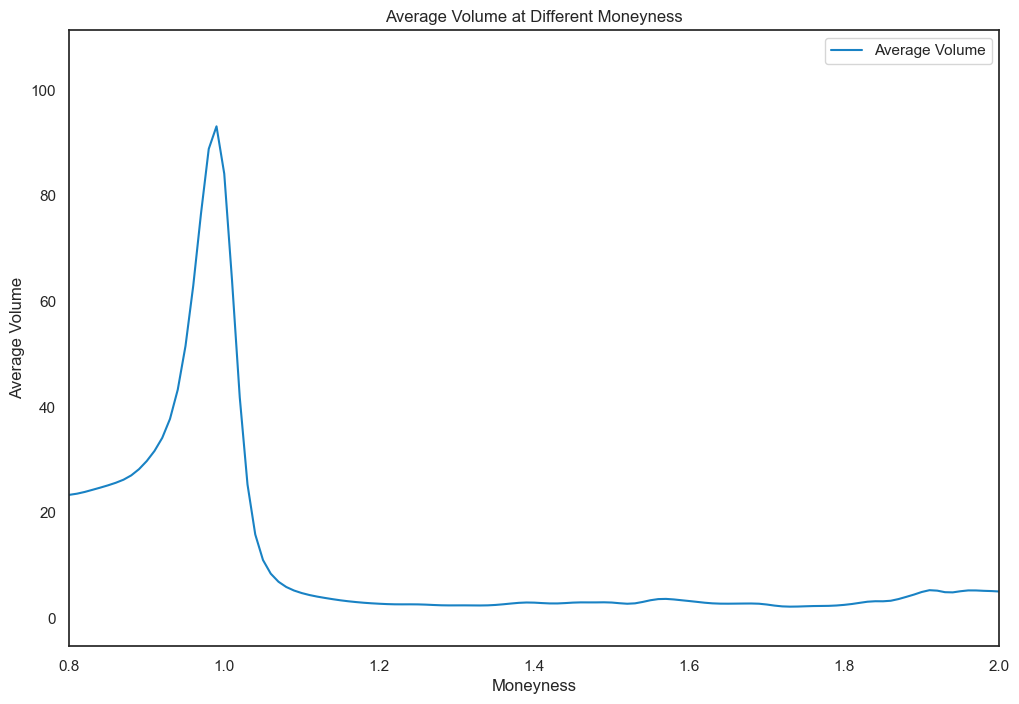

In [8]:
df = df_copy.copy()
# Add moneyness column
df["Moneyness"] = df["[UNDERLYING_LAST]"] / df["[STRIKE]"]

# Round moneyness into 100 bins
df["Moneyness"] = df["Moneyness"].round(2)

# Group by Moneyness instead
df_grouped = df.groupby("Moneyness")["Volume"].mean().reset_index()
df_grouped["Average Volume"] = df_grouped["Volume"]
df_grouped["Average Volume"] = gaussian_filter1d(df_grouped["Average Volume"], sigma=1.5)

# Compute average for Moneyness > 2 and Moneyness < 2
average_volume_2 = df[df["Moneyness"] > 2]["Volume"].mean()
average_volume_0_2 = df[df["Moneyness"] < 2]["Volume"].mean()

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_grouped, x="Moneyness", y="Average Volume", label='Average Volume', color=color)
plt.title("Average Volume at Different Moneyness")
plt.xlabel("Moneyness")
plt.ylabel("Average Volume")
plt.xlim(0.8, 2)
plt.legend()
plt.show()



In [9]:
average_volume_2 = df[df["Moneyness"] > 2]["Average Volume"].mean()
average_volume_0_2 = df[df["Moneyness"] < 0.8]["Average Volume"].mean()
average_volume_between = df[(df["Moneyness"] > 0.8) & (df["Moneyness"] < 2)]["Average Volume"].mean()

In [10]:
print("Average Volume for Moneyness > 2.0: " + str(average_volume_2))
print("Average Volume for Moneyness < 0.8: " + str(average_volume_0_2))
print("Average volume for 0.8-2.0: " + str(average_volume_between))

Average Volume for Moneyness > 2.0: 6.437662618246697
Average Volume for Moneyness < 0.8: 19.12157713813725
Average volume for 0.8-2.0: 24.20356147653162


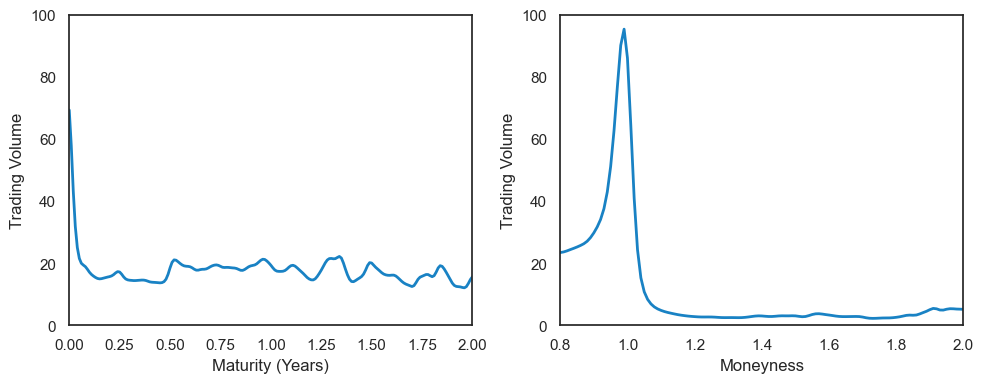

In [11]:
df = df_copy.copy()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

df["Date"] = pd.to_datetime(df["[QUOTE_DATE]"])
df["Maturity"] = (pd.to_datetime(df["[EXPIRE_DATE]"]) - df["Date"]).dt.days / 365
df["Maturity"] = df["Maturity"].round(2)
df["Volume"] = pd.to_numeric(df["[C_VOLUME]"].fillna(0), errors='coerce')

df_mat = df.groupby("Maturity")["Volume"].mean().reset_index()
df_mat["Average Volume"] = df_mat["Volume"]

# Add moneyness column
df["Moneyness"] = df["[UNDERLYING_LAST]"] / df["[STRIKE]"]

# Round moneyness into 100 bins
df["Moneyness"] = df["Moneyness"].round(2)

df_money = df.groupby("Moneyness")["Volume"].mean().reset_index()
df_money["Average Volume"] = df_money["Volume"]

# Smooth mat using gaussian filter
df_mat["Average Volume"] = gaussian_filter1d(df_mat["Average Volume"], sigma=1.5)
df_money["Average Volume"] = gaussian_filter1d(df_money["Average Volume"], sigma=1.4)


sns.lineplot(data=df_mat, x="Maturity", y="Average Volume", label='Average Volume', color=color, ax=axs[0], legend=False, linewidth=2)
axs[0].set_xlabel("Maturity (Years)")
axs[0].set_ylabel("Trading Volume")
axs[0].set_xlim(0, 2)
axs[0].set_ylim(0, 100)

df["Moneyness"] = df["[UNDERLYING_LAST]"] / df["[STRIKE]"]
df["Moneyness"] = df["Moneyness"].round(2)

df_grouped = df.groupby("Moneyness")["Volume"].mean().reset_index()
df_grouped["Average Volume"] = df_grouped["Volume"]

sns.lineplot(data=df_money, x="Moneyness", y="Average Volume", label='Average Volume', color=color, ax=axs[1], legend=False, linewidth=2)
axs[1].set_xlabel("Moneyness")
axs[1].set_ylabel("Trading Volume")
axs[1].set_xlim(0.8, 2)
axs[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()